2024-12-01 17:23:29,259 - INFO - Clearing existing MongoDB data...
2024-12-01 17:23:29,266 - INFO - MongoDB data cleared.
2024-12-01 17:23:29,276 - INFO - Starting data loading...
2024-12-01 17:23:29,279 - INFO - Loading file: coronatrain.csv
2024-12-01 17:24:29,694 - INFO - Successfully inserted data from coronatrain.csv.
2024-12-01 17:24:29,696 - INFO - Loading file: Corona_NLP_test -1.csv
2024-12-01 17:24:31,347 - INFO - Successfully inserted data from Corona_NLP_test -1.csv.
2024-12-01 17:24:31,348 - INFO - Loading file: Corona_NLP_test -2.csv
2024-12-01 17:24:32,721 - INFO - Successfully inserted data from Corona_NLP_test -2.csv.
2024-12-01 17:24:32,726 - INFO - CSV data loaded into MongoDB.


UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
...,...,...,...,...,...


2024-12-01 17:24:33,223 - INFO - Fetched and displayed MongoDB data.


<Figure size 1000x600 with 0 Axes>

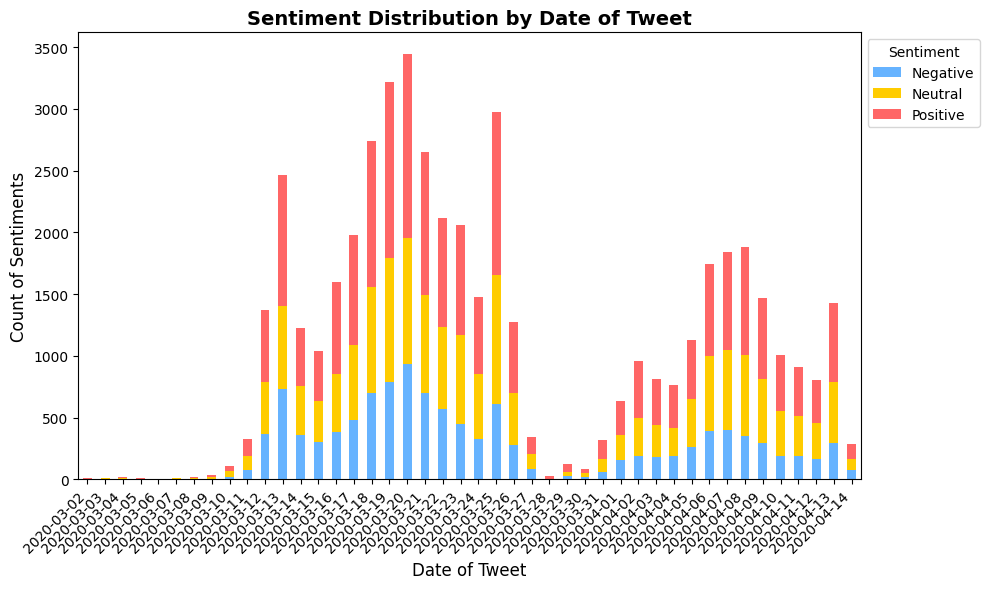

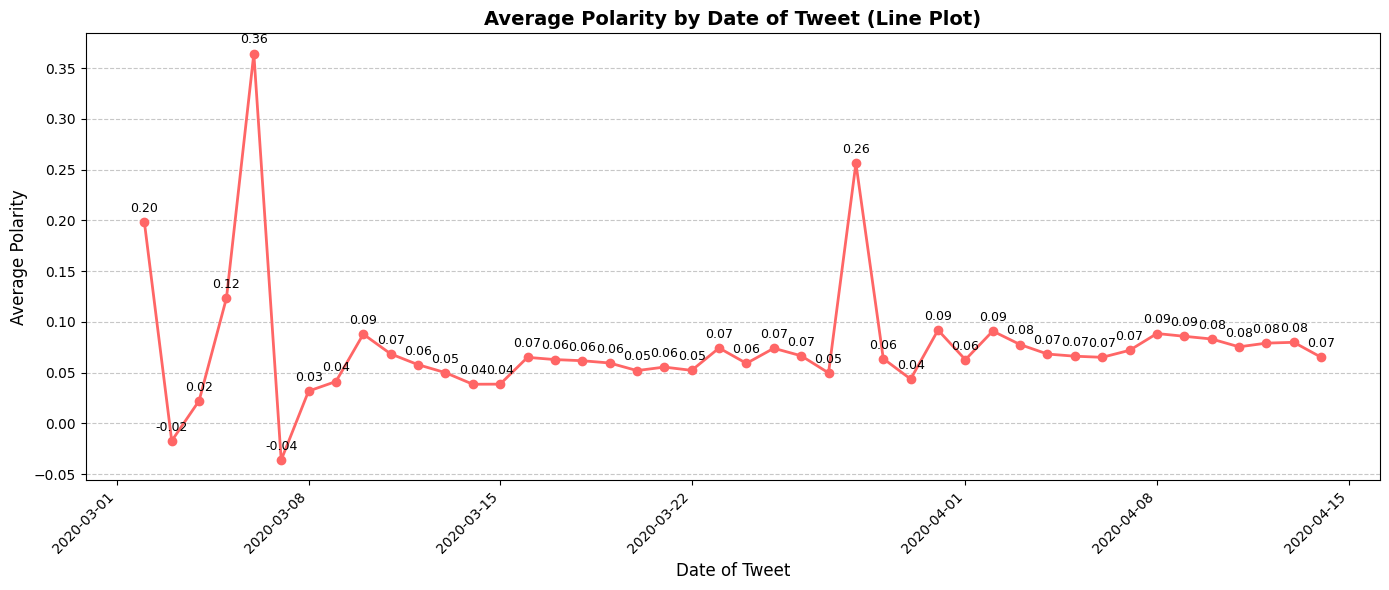

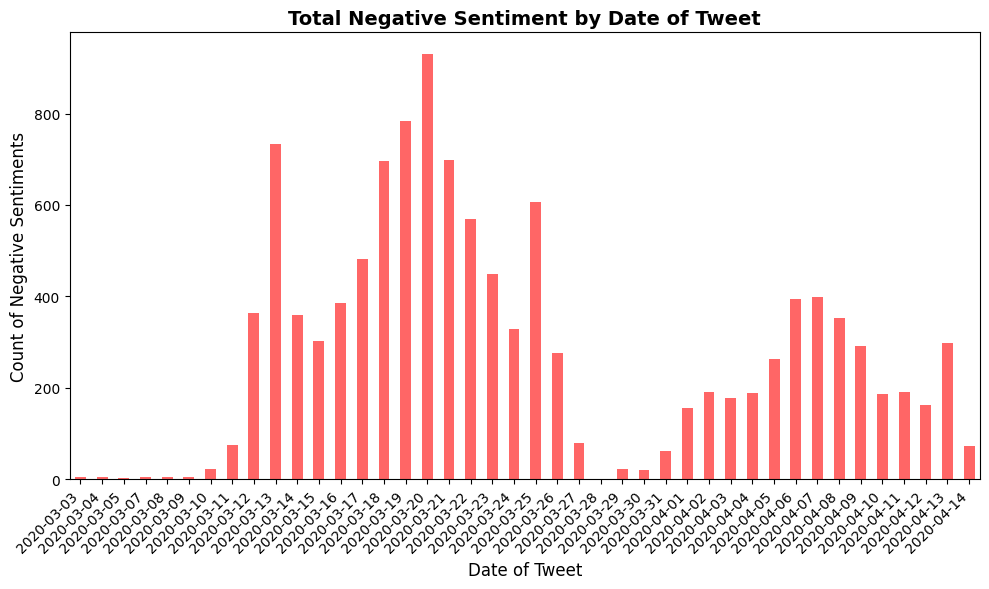

2024-12-01 17:25:12,261 - INFO - Sentiment analysis and visualization completed.
2024-12-01 17:25:12,558 - INFO - Spark session stopped.


In [1]:
import threading
import pandas as pd
import os
from pyspark.sql import SparkSession
from pymongo import MongoClient
from IPython.display import display, HTML
from textblob import TextBlob
import matplotlib.pyplot as plt
import logging
from colorama import init, Fore, Style

# Initialize colorama
init()

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


class SentimentAnalysisPipeline:
    def __init__(self, folder_path, mongo_uri, mongo_db, mongo_collection, spark_master_url):
        self.folder_path = folder_path
        self.mongo_uri = mongo_uri
        self.mongo_db = mongo_db
        self.mongo_collection = mongo_collection
        self.spark_master_url = spark_master_url
        self.client = MongoClient(self.mongo_uri)
        self.db = self.client[self.mongo_db]
        self.collection = self.db[self.mongo_collection]
        self.spark = SparkSession.builder \
            .appName("MasterSlaveProject") \
            .master(self.spark_master_url) \
            .config("spark.mongodb.input.uri", f"{self.mongo_uri}/{self.mongo_db}.{self.mongo_collection}") \
            .config("spark.mongodb.output.uri", f"{self.mongo_uri}/{self.mongo_db}.{self.mongo_collection}") \
            .getOrCreate()

    def clear_mongo_data(self):
        """Clear existing MongoDB data."""
        logging.info(Fore.YELLOW + "Clearing existing MongoDB data..." + Style.RESET_ALL)
        self.collection.delete_many({})

    def load_csv_to_mongo(self):
        """Load CSV files from folder into MongoDB."""
        csv_files = [f for f in os.listdir(self.folder_path) if f.endswith('.csv')]
        logging.info(Fore.BLUE + "Starting data loading..." + Style.RESET_ALL)
        for csv_file in csv_files:
            file_path = os.path.join(self.folder_path, csv_file)
            try:
                logging.info(Fore.BLUE + f"Loading file: {csv_file}" + Style.RESET_ALL)
                df = self.spark.read.csv(file_path, header=True, inferSchema=True)
                pandas_df = df.toPandas().drop_duplicates()  # Remove duplicates
                data_dict = pandas_df.to_dict(orient="records")
                self.collection.insert_many(data_dict)
                logging.info(Fore.GREEN + f"Successfully inserted data from {csv_file}." + Style.RESET_ALL)
            except Exception as e:
                logging.error(Fore.RED + f"Error loading data from {csv_file}: {e}" + Style.RESET_ALL)

    def get_sentiment(self, text):
        """Perform sentiment analysis on a given text."""
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        if polarity > 0:
            return 'Positive'
        elif polarity == 0:
            return 'Neutral'
        else:
            return 'Negative'

    def fetch_and_display_mongo_data(self):
        """Fetch data from MongoDB and display only the first 3 rows and last row."""
        try:
            total_rows = self.collection.count_documents({})  # Count total rows in the collection

            # Display the total rows with a larger font size
            display(HTML(f"<p style='font-size:20px; font-weight:bold;'>Total rows in MongoDB collection: {total_rows}</p>"))

            # Fetch all data from the collection
            data = list(self.collection.find())

            if len(data) > 4:  # Show only the first 3 and last row if there are enough rows
                data_to_display = data[:3] + [data[-1]]
                df = pd.DataFrame(data_to_display)
                df.loc[3] = ['...'] * len(df.columns)  # Add an ellipsis row
            else:
                # If the collection has fewer rows, display them all
                df = pd.DataFrame(data)

            # Drop the '_id' column if it exists, for a cleaner display
            df = df.drop(columns=['_id'], errors='ignore')

            # Style the table with frame and better design
            table_html = df.to_html(classes='table table-bordered table-hover', border=1, index=False)

            # Custom CSS for better presentation of the table
            custom_css = """
            <style>
            .table {
                width: 100%;
                margin: 20px 0;
                border-collapse: collapse;
            }
            .table-bordered {
                border: 2px solid #ddd;
            }
            .table-bordered th, .table-bordered td {
                padding: 10px;
                text-align: left;
                border: 1px solid #ddd;
            }
            .table-bordered th {
                background-color: #f2f2f2;
                font-weight: bold;
            }
            .table-hover tbody tr:hover {
                background-color: #f5f5f5;
            }
            </style>
            """

            # Display the styled table with a frame
            display(HTML(custom_css + table_html))
        
        except Exception as e:
            logging.error(Fore.RED + f"Error displaying MongoDB data: {e}" + Style.RESET_ALL)

    def analyze_and_visualize(self):
        """Perform sentiment analysis and visualize results."""
        try:
            data = list(self.collection.find())
            df = pd.DataFrame(data)
            df = df.drop(columns=['_id'], errors='ignore')
            df['sentiment'] = df['OriginalTweet'].apply(self.get_sentiment)
            df['polarity'] = df['OriginalTweet'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)

            df['TweetAt'] = pd.to_datetime(df['TweetAt'], errors='coerce', dayfirst=True)

            sentiment_by_date = df.groupby([df['TweetAt'].dt.date, 'sentiment']).size().unstack(fill_value=0)
            polarity_by_date = df.groupby(df['TweetAt'].dt.date)['polarity'].mean().reset_index()

            # Sentiment distribution plot
            plt.figure(figsize=(10, 6))
            sentiment_by_date.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#66b3ff', '#ffcc00', '#ff6666'])
            plt.title('Sentiment Distribution by Date of Tweet', fontsize=14, fontweight='bold')
            plt.xlabel('Date of Tweet', fontsize=12)
            plt.ylabel('Count of Sentiments', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.legend(title='Sentiment', loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()

            # Polarity plot
            plt.figure(figsize=(14, 6))
            plt.plot(polarity_by_date['TweetAt'], polarity_by_date['polarity'], color='#ff6666', marker='o', linestyle='-', linewidth=2)
            plt.title('Average Polarity by Date of Tweet (Line Plot)', fontsize=14, fontweight='bold')
            plt.xlabel('Date of Tweet', fontsize=12)
            plt.ylabel('Average Polarity', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            for i, value in enumerate(polarity_by_date['polarity']):
                plt.text(polarity_by_date['TweetAt'][i], value + 0.01, f'{value:.2f}', ha='center', fontsize=9, color='black')
            plt.tight_layout()
            plt.show()

            # Total Negative Sentiment by Date of Tweet
            negative_sentiment_by_date = df[df['sentiment'] == 'Negative'].groupby(df['TweetAt'].dt.date).size()

            plt.figure(figsize=(10, 6))
            negative_sentiment_by_date.plot(kind='bar', color='#ff6666')
            plt.title('Total Negative Sentiment by Date of Tweet', fontsize=14, fontweight='bold')
            plt.xlabel('Date of Tweet', fontsize=12)
            plt.ylabel('Count of Negative Sentiments', fontsize=12)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            logging.error(Fore.RED + f"Error during analysis and visualization: {e}" + Style.RESET_ALL)

    def run(self):
        """Run the full pipeline."""
        self.clear_mongo_data()
        logging.info(Fore.GREEN + "MongoDB data cleared." + Style.RESET_ALL)
        self.load_csv_to_mongo()
        logging.info(Fore.GREEN + "CSV data loaded into MongoDB." + Style.RESET_ALL)
        self.fetch_and_display_mongo_data()
        logging.info(Fore.GREEN + "Fetched and displayed MongoDB data." + Style.RESET_ALL)
        self.analyze_and_visualize()
        logging.info(Fore.GREEN + "Sentiment analysis and visualization completed." + Style.RESET_ALL)

        # Stop Spark session after completing the tasks
        self.spark.stop()
        logging.info(Fore.GREEN + "Spark session stopped." + Style.RESET_ALL)


# Main Execution
if __name__ == "__main__":
    folder_path = r"C:\Users"
    mongo_uri = "mongodb://localhost:27017/"
    mongo_db = "UserDatabase"
    mongo_collection = "UserCollection"
    # spark_master_url = "spark://192.168.250.35:7077"
    spark_master_url = "spark://172.20.10.3:7077"
    pipeline = SentimentAnalysisPipeline(folder_path, mongo_uri, mongo_db, mongo_collection, spark_master_url)
    pipeline.run()
